<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Vinod_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as stats

In [13]:
!pip install qnorm
import qnorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [14]:
genes_Y_crom = genes[genes.chrom == "Y"].index
genes_bac_index = genes[genes.chrom.isnull()].index
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)
expression_qnorm = qnorm.quantile_normalize(expression, axis=0)

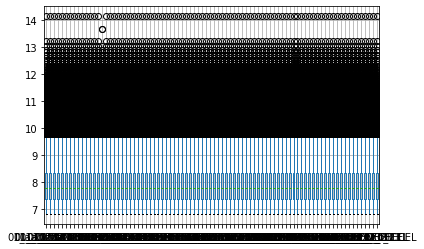

In [17]:
# expression.T.boxplot()
# expression_norm.T.boxplot()
expression_qnorm.T.boxplot()

In [28]:
express_norm_samp = pd.concat([expression_qnorm, samples], axis=1)
express_samp_loc = express_norm_samp
c = 0
for tissue in express_samp_loc["region"].unique():
  print(tissue)
  df_male = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "male")]
  df_female = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "female")]

  male_mean = expression_qnorm.loc[df_male.index].mean()
  female_mean = expression_qnorm.loc[df_female.index].mean()

  diff = np.abs(male_mean - female_mean)
  diff = diff.sort_values(ascending=False)
  top_10 = diff.iloc[:10]
  op_chrom = genes.loc[top_10.keys()].loc[:, 'chrom'].values
  op_genes = genes.loc[top_10.keys()].loc[:, 'sym'].values
  chrom_counter = Counter(op_chrom)
  count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
  print(count)
  print(op_chrom, op_genes)
  print("")
  c += 1





A.C. cortex
3
['Y', 'Y', '11', '16hba1', '3', 'X', '12', '6', '8', '11']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'DDX3Y', 'HBB', NaN, 'MOBP', 'PLP1', 'GAPDH', 'RPS12', 'ENPP2', 'HBB']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

cerebellum
3
['Y', 'Y', '11', 'X', '11', '16hba1', '4', '18', '17', '11']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'DDX3Y', 'HBB', 'PLP1', 'HBB', NaN, 'SPP1', 'MBP', 'GFAP', 'CRYAB']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

D.L.P.F. cortex
4
['Y', 'Y', '11', '16hba1', '2', '11', '4', '2', 'Y', 'X']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'DDX3Y', 'HBB', NaN, 'IGFBP5', 'HBB', 'SPP1', 'IGFBP5', 'KDM5D', 'XIST']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZY

In [39]:
express_norm_samp = pd.concat([expression_norm, samples], axis=1)
express_samp_loc = express_norm_samp
c = 0
for tissue in express_samp_loc["region"].unique():
  print(tissue)
  df_male = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "male")]
  df_female = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "female")]

  unique_genes = expression_norm.columns
  p_values= []

  for gene in unique_genes:
    stat, p = stats.ttest_ind(a=expression_norm.loc[df_male.index][gene], b=expression_norm.loc[df_female.index][gene], equal_var=False)
    p_values.append((p, gene))

  sorted_pval = sorted(p_values, key=lambda tup: tup[0])
  top10genes = [tup[1] for tup in sorted_pval[:10]]
  # print(top10genes)

  



  # male_mean = expression_norm.loc[df_male.index].mean()
  # female_mean = expression_norm.loc[df_female.index].mean()

  # diff = np.abs(male_mean - female_mean)
  # diff = diff.sort_values(ascending=False)
  # top_10 = diff.iloc[:10]
  op_chrom = genes.loc[top10genes].loc[:, 'chrom'].values
  op_genes = genes.loc[top10genes].loc[:, 'sym'].values
  chrom_counter = Counter(op_chrom)
  count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
  print(count)
  print(op_chrom, op_genes)
  print("")
  c += 1





A.C. cortex
6
['Y', 'Y', 'X', 'Y', 'Y', 'Y', '21', NaN, '8', '2']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['KDM5D', 'RPS4Y1', 'XIST', 'UTY', 'DDX3Y', 'USP9Y', 'OLIG2', NaN, 'IKBKB', 'AGPS']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

cerebellum
7
['Y', 'Y', 'X', '6', 'Y', 'Y', 'Y', NaN, 'Y', '11']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['KDM5D', 'RPS4Y1', 'XIST', 'CD24', 'TTTY15', 'USP9Y', 'DDX3Y', NaN, 'UTY', 'CD44']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

D.L.P.F. cortex
9
['Y', 'Y', 'Y', 'X', 'Y', 'Y', 'Y', 'Y', 'X', '6']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'KDM5D', 'DDX3Y', 'XIST', 'TTTY15', 'NLGN4Y', 'UTY', 'USP9Y', NaN, 'HIST1H3I']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1

In [ ]:
express_norm_samp = pd.concat([expression_qnorm, samples], axis=1)
express_samp_loc = express_norm_samp
c = 0
for tissue in express_samp_loc["region"].unique():
  print(tissue)
  df_male = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "male")]
  df_female = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "female")]

  unique_genes = expression_qnorm.columns
  p_values= []

  for gene in unique_genes:
    stat, p = stats.ttest_ind(a=expression_qnorm.loc[df_male.index][gene], b=expression_qnorm.loc[df_female.index][gene], equal_var=False)
    p_values.append((p, gene))

  sorted_pval = sorted(p_values, key=lambda tup: tup[0])
  top10genes = [tup[1] for tup in sorted_pval[:10]]
  # print(top10genes)

  



  # male_mean = expression_norm.loc[df_male.index].mean()
  # female_mean = expression_norm.loc[df_female.index].mean()

  # diff = np.abs(male_mean - female_mean)
  # diff = diff.sort_values(ascending=False)
  # top_10 = diff.iloc[:10]
  op_chrom = genes.loc[top10genes].loc[:, 'chrom'].values
  op_genes = genes.loc[top10genes].loc[:, 'sym'].values
  chrom_counter = Counter(op_chrom)
  count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
  print(count)
  print(op_chrom, op_genes)
  print("")
  c += 1





A.C. cortex
